In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import itertools

from keras.callbacks import History, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Input, GRU, Embedding, LSTM, Dropout


Using TensorFlow backend.


In [2]:
df = pd.read_csv("C:/Users/pio-f/Desktop/DoS_dataset.csv")
df.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,0316,8,05,21,68,09,21,21,00,6f,R
1,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
2,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
3,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
4,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R


In [3]:
dataset = pd.read_csv("C:/Users/pio-f/Desktop/DoS_dataset.csv", converters={"DATA0":lambda x: int(x, 16),"DATA1":lambda x: int(x, 16),"DATA2":lambda x: int(x, 16),"DATA3":lambda x: int(x, 16),"DATA4":lambda x: int(x, 16),"DATA5":lambda x: int(x, 16),"DATA6":lambda x: int(x, 16),"DATA7":lambda x: int(x, 16)})
dataset.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,0316,8,5,33,104,9,33,33,0,111,R
1,1.478198e+09,018f,8,254,91,0,0,0,60,0,0,R
2,1.478198e+09,0260,8,25,33,34,48,8,142,109,58,R
3,1.478198e+09,02a0,8,100,0,154,29,151,2,189,0,R
4,1.478198e+09,0329,8,64,187,127,20,17,32,0,20,R


In [4]:
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], origin=pd.Timestamp('2020-01-01'))
dataset.sort_values(by = ["Timestamp","CAN ID"], inplace = True)
dataset.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T


In [5]:
dataset.set_index('Timestamp').head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
Timestamp,,,,,,,,,,,
2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T


In [6]:
DoST = dataset[dataset["Flag"] == "T"]
DoSR = dataset[dataset["Flag"] == "R"]

In [7]:
DoST.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T


In [8]:
DoSR.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
6,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,11,17,R
27,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,12,66,R
42,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,13,95,R
65,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,14,120,R
80,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,15,101,R


In [9]:
DoST2 = DoST.iloc[0:200000, 0:12]

In [10]:
DoST2

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
902995,2020-01-01 00:00:01.478199040,0000,8,0,0,0,0,0,0,0,0,T
902996,2020-01-01 00:00:01.478199040,0000,8,0,0,0,0,0,0,0,0,T
902998,2020-01-01 00:00:01.478199040,0000,8,0,0,0,0,0,0,0,0,T
903000,2020-01-01 00:00:01.478199040,0000,8,0,0,0,0,0,0,0,0,T


In [11]:
DoSR2 = DoSR.iloc[0:50000, 0:12]

In [12]:
DoSR2

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
6,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,11,17,R
27,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,12,66,R
42,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,13,95,R
65,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,14,120,R
80,2020-01-01 00:00:01.478198272,0002,8,0,0,0,0,0,3,15,101,R
...,...,...,...,...,...,...,...,...,...,...,...,...
289974,2020-01-01 00:00:01.478198528,0130,8,23,128,0,255,55,128,5,57,R
289996,2020-01-01 00:00:01.478198528,0130,8,25,128,0,255,38,128,6,136,R
290011,2020-01-01 00:00:01.478198528,0130,8,24,128,0,255,12,128,7,247,R
290033,2020-01-01 00:00:01.478198528,0130,8,19,128,0,255,13,128,8,246,R


In [19]:
frames = [DoST2,DoSR2]
DoS = pd.concat(frames)
DoS

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
289974,2020-01-01 00:00:01.478198528,0130,8,23,128,0,255,55,128,5,57,R
289996,2020-01-01 00:00:01.478198528,0130,8,25,128,0,255,38,128,6,136,R
290011,2020-01-01 00:00:01.478198528,0130,8,24,128,0,255,12,128,7,247,R
290033,2020-01-01 00:00:01.478198528,0130,8,19,128,0,255,13,128,8,246,R


In [20]:
fuzzy = pd.read_csv("C:/Users/pio-f/Desktop/Fuzzy2_dataset.csv", converters={"DATA0":lambda x: int(x, 16),"DATA1":lambda x: int(x, 16),"DATA2":lambda x: int(x, 16),"DATA3":lambda x: int(x, 16),"DATA4":lambda x: int(x, 16),"DATA5":lambda x: int(x, 16),"DATA6":lambda x: int(x, 16),"DATA7":lambda x: int(x, 16)})
fuzzy.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,0545,8,216,0,0,138,0,0,0,0,R
1,1.478196e+09,0002,8,0,0,0,0,0,1,7,21,R
2,1.478196e+09,0153,8,0,33,16,255,0,255,0,0,R
3,1.478196e+09,0130,8,25,128,0,255,254,127,7,96,R
4,1.478196e+09,0131,8,23,128,0,0,101,127,7,159,R


In [21]:
fuzzy['Timestamp'] = pd.to_datetime(fuzzy['Timestamp'], origin=pd.Timestamp('2020-01-01'))
fuzzy.sort_values(by = ["Timestamp","CAN ID"], inplace = True)
fuzzy.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
15533,2020-01-01 00:00:01.478195712,0000,8,219,128,220,27,141,193,95,50,T
37822,2020-01-01 00:00:01.478195712,0000,8,95,237,27,121,90,194,232,137,T
74417,2020-01-01 00:00:01.478195712,0000,8,193,22,103,217,138,195,153,172,T
81264,2020-01-01 00:00:01.478195712,0000,8,181,120,186,73,120,239,121,218,T
88344,2020-01-01 00:00:01.478195712,0000,8,70,194,36,16,81,129,95,217,T


In [22]:
fuzzy.set_index('Timestamp').head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
Timestamp,,,,,,,,,,,
2020-01-01 00:00:01.478195712,0000,8,219,128,220,27,141,193,95,50,T
2020-01-01 00:00:01.478195712,0000,8,95,237,27,121,90,194,232,137,T
2020-01-01 00:00:01.478195712,0000,8,193,22,103,217,138,195,153,172,T
2020-01-01 00:00:01.478195712,0000,8,181,120,186,73,120,239,121,218,T
2020-01-01 00:00:01.478195712,0000,8,70,194,36,16,81,129,95,217,T


In [23]:
fuzzyT = fuzzy[fuzzy["Flag"] == "T"]

In [26]:
fuzzyR = fuzzy[fuzzy["Flag"] == "R"]

In [27]:
fuzzyF2 = fuzzyT.iloc[0:200000, 0:12]
fuzzyF2

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
15533,2020-01-01 00:00:01.478195712,0000,8,219,128,220,27,141,193,95,50,T
37822,2020-01-01 00:00:01.478195712,0000,8,95,237,27,121,90,194,232,137,T
74417,2020-01-01 00:00:01.478195712,0000,8,193,22,103,217,138,195,153,172,T
81264,2020-01-01 00:00:01.478195712,0000,8,181,120,186,73,120,239,121,218,T
88344,2020-01-01 00:00:01.478195712,0000,8,70,194,36,16,81,129,95,217,T
...,...,...,...,...,...,...,...,...,...,...,...,...
1038949,2020-01-01 00:00:01.478196480,0475,8,55,92,119,132,104,5,125,21,T
1052116,2020-01-01 00:00:01.478196480,0475,8,129,111,47,171,207,103,67,208,T
1056148,2020-01-01 00:00:01.478196480,0475,8,8,154,61,134,146,144,93,78,T
1065711,2020-01-01 00:00:01.478196480,0475,8,190,237,137,179,190,109,11,108,T


In [28]:
fuzzyR2 = fuzzyR.iloc[0:50000, 0:12]
fuzzyR2

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1,2020-01-01 00:00:01.478195712,0002,8,0,0,0,0,0,1,7,21,R
22,2020-01-01 00:00:01.478195712,0002,8,0,0,0,0,0,1,8,174,R
40,2020-01-01 00:00:01.478195712,0002,8,0,0,0,0,0,1,9,179,R
61,2020-01-01 00:00:01.478195712,0002,8,0,0,0,0,0,1,10,148,R
76,2020-01-01 00:00:01.478195712,0002,8,0,0,0,0,0,1,11,137,R
...,...,...,...,...,...,...,...,...,...,...,...,...
90380,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R
90397,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R
90417,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R
90434,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R


In [29]:
spoof = pd.read_csv("C:/Users/pio-f/Desktop/gear2_dataset.csv", converters={"DATA0":lambda x: int(x, 16),"DATA1":lambda x: int(x, 16),"DATA2":lambda x: int(x, 16),"DATA3":lambda x: int(x, 16),"DATA4":lambda x: int(x, 16),"DATA5":lambda x: int(x, 16),"DATA6":lambda x: int(x, 16),"DATA7":lambda x: int(x, 16)})
spoof.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,0140,8,0,0,0,0,16,41,42,36,R
1,1.478193e+09,02c0,8,21,0,0,0,0,0,0,0,R
2,1.478193e+09,0350,8,5,32,68,104,119,0,0,126,R
3,1.478193e+09,0370,8,0,32,0,0,0,0,0,0,R
4,1.478193e+09,043f,8,16,64,96,255,120,196,8,0,R


In [30]:
spoof['Timestamp'] = pd.to_datetime(spoof['Timestamp'], origin=pd.Timestamp('2020-01-01'))
spoof.sort_values(by = ["Timestamp","CAN ID"], inplace = True)
spoof.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
8,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,6,11,112,R
32,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,12,111,R
44,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,13,114,R
68,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,14,246,R
81,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,15,235,R


In [31]:
spoof.set_index('Timestamp').head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
Timestamp,,,,,,,,,,,
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,6,11,112,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,12,111,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,13,114,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,14,246,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,15,235,R


In [32]:
spoofT = spoof[spoof["Flag"] == "T"]

In [33]:
SpoofR = spoof[spoof["Flag"] =="R"]

In [71]:
spoofS2 = spoofT.iloc[0:200000, 0:12]
spoofS2

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
2116,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2117,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2118,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2120,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2126,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
1160857,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T
1160859,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T
1160860,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T
1160863,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T


In [72]:
spoofR2 = SpoofR.iloc[0:50000, 0:12]
spoofR2

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
8,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,6,11,112,R
32,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,12,111,R
44,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,13,114,R
68,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,14,246,R
81,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,15,235,R
...,...,...,...,...,...,...,...,...,...,...,...,...
171413,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171434,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171449,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171469,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R


In [73]:
frames = [DoS,fuzzyF2]
DoS2 = pd.concat(frames)
DoS2

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
1038949,2020-01-01 00:00:01.478196480,0475,8,55,92,119,132,104,5,125,21,T
1052116,2020-01-01 00:00:01.478196480,0475,8,129,111,47,171,207,103,67,208,T
1056148,2020-01-01 00:00:01.478196480,0475,8,8,154,61,134,146,144,93,78,T
1065711,2020-01-01 00:00:01.478196480,0475,8,190,237,137,179,190,109,11,108,T


In [74]:
frames = [DoS2,fuzzyR2]
DoS3 = pd.concat(frames)
DoS3

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
90380,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R
90397,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R
90417,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R
90434,2020-01-01 00:00:01.478195712,02c0,8,21,0,0,0,0,0,0,0,R


In [75]:
frames = [DoS3,spoofS2]
DoS4 = pd.concat(frames)
DoS4

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
1160857,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T
1160859,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T
1160860,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T
1160863,2020-01-01 00:00:01.478193920,043f,8,1,69,96,255,107,0,0,0,T


In [76]:
frames = [DoS4,spoofR2]
DoS5 = pd.concat(frames)
DoS5

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
171413,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171434,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171449,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171469,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R


In [77]:
frames = [DoS4,spoofR2]
DoS5 = pd.concat(frames)
DoS5

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
1460,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1462,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1464,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1466,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
1468,2020-01-01 00:00:01.478198272,0000,8,0,0,0,0,0,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
171413,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171434,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171449,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R
171469,2020-01-01 00:00:01.478193152,018f,8,254,66,0,0,0,60,0,0,R


In [78]:
DoS5['Flag'].unique()

array(['T', 'R'], dtype=object)

In [79]:
dataset = DoS5

In [80]:
dataset['Flag'].unique()

array(['T', 'R'], dtype=object)

In [81]:
dataset['Flag'].unique()

array(['T', 'R'], dtype=object)

In [82]:
#Variabili da inserire nel modello per il dataset T
X_DoS = dataset[['DATA0','DATA1','DATA2','DATA3','DATA4','DATA5','DATA6','DATA7']].values
y_DoS = dataset['Flag'].values

In [83]:
def temporalize(X,y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback):
        t = []
        for j in range(0, lookback):
            t.append(X[[i+j], :])
        output_X.append(t)
        output_y.append(y[i+lookback])
    return output_X,output_y

In [84]:
le = LabelEncoder()
y_DoS = le.fit_transform(y_DoS)

In [85]:
X_t, y_t = temporalize(X = X_DoS, y=y_DoS, lookback=10)

In [86]:
X_t = np.array(X_t)

In [87]:
X_t = X_t.reshape(X_t.shape[0],10,8)

In [88]:
X_t.shape

(749990, 10, 8)

In [89]:
y_t = np.array(y_t)

In [90]:
y_t.shape

(749990,)

In [91]:
y_t

array([1, 1, 1, ..., 0, 0, 0])

In [92]:
y_t2 = to_categorical(y_t, 2)
y_t2[0]
y_t2.shape

(749990, 2)

In [93]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_t, y_t2, test_size=0.3)

In [94]:
X2_train[0]

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [95]:
y2_train[0]

array([0., 1.], dtype=float32)

In [96]:
#L'input del modello si basa sui dati del dataset DoSR
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(10,8)))
model.add(Dropout(0.2))
model.add(LSTM(40, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(40, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation="softmax" ))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 20)            2320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 40)            9760      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 60)            24240     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 40)                16160     
__________

In [97]:
model.compile(optimizer='rmsprop' , loss= 'mean_squared_error', metrics=['accuracy'])

In [98]:
#model.compile(optimizer='rmsprop' , loss= 'categorical_crossentropy', metrics=['accuracy'])

In [99]:
history = History()

In [100]:
model.fit(X2_train, y2_train, epochs=5, batch_size = 1000, validation_split=0.1, callbacks=[history])

Train on 472493 samples, validate on 52500 samples
Epoch 1/5
472493/472493 [==============================] - 66s 139us/step - loss: 0.0073 - acc: 0.9921 - val_loss: 8.3317e-04 - val_acc: 0.9992
Epoch 2/5
472493/472493 [==============================] - 65s 137us/step - loss: 9.3733e-04 - acc: 0.9991 - val_loss: 8.2145e-04 - val_acc: 0.9992
Epoch 3/5
472493/472493 [==============================] - 65s 137us/step - loss: 9.3240e-04 - acc: 0.9991 - val_loss: 8.1807e-04 - val_acc: 0.9992
Epoch 4/5
472493/472493 [==============================] - 63s 134us/step - loss: 9.2037e-04 - acc: 0.9991 - val_loss: 8.1856e-04 - val_acc: 0.9992
Epoch 5/5
472493/472493 [==============================] - 64s 135us/step - loss: 9.1884e-04 - acc: 0.9991 - val_loss: 8.1820e-04 - val_acc: 0.9992


In [101]:
model.evaluate(X2_test, y2_test)

224997/224997 [==============================] - 26s 117us/step


[0.000846890235245892, 0.9991510997924417]

In [102]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [103]:
y_pred = model.predict_classes(X2_test, batch_size=1000, verbose = 0)

In [104]:
y_labels = np.argmax(y2_test, axis=1)

In [105]:
mc = confusion_matrix(y_labels, y_pred)

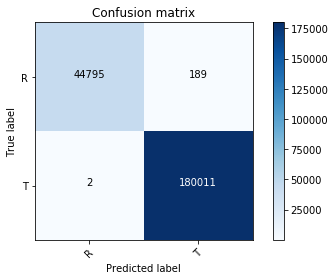

In [108]:
plot_confusion_matrix(mc, ['R','T'])

In [250]:
#history = model.fit(X2_train, y2_train, epochs=5, batch_size = 1000, validation_split=0.1, verbose=0)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


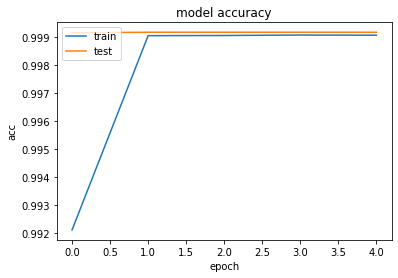

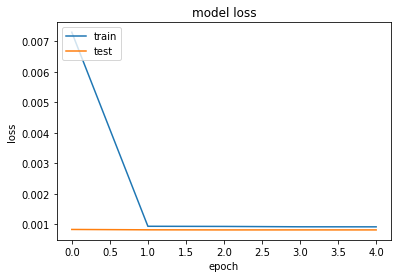

In [109]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()